### Parameters

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
# import mpld3
from datetime import datetime, timedelta

pd.set_option('chained_assignment', None)
plt.style.use('seaborn-darkgrid')
# mpld3.enable_notebook()
%matplotlib inline

In [2]:
# For intra-day trading, we only will work with one date at a time
date = datetime(2017, 10, 19)

# Names of files for each Bitcoin data set
data_sets = {
    'coinbase': 'coinbaseUSD_1-min_data_2014-12-01_to_2017-10-20.csv',
    'coincheck': 'coincheckJPY_1-min_data_2014-10-31_to_2017-10-20.csv',
    'bitstamp': 'bitstampUSD_1-min_data_2012-01-01_to_2017-10-20.csv'
}

data_dir = './data'

### Read in data

In [3]:
def read_data(path):
    print("hello world")
    next_date = date + timedelta(days=1)
#     print(next_date)
    df = (
        pd
        .read_csv(os.path.join(data_dir, path))  # 操作系统等待读取文件完成
        .assign(Timestamp = lambda x: pd.to_datetime(x.Timestamp, unit='s'))
        .rename(columns={'Volume_(BTC)':'volume', 'Weighted_Price':'price'})
        .loc[lambda x: (x.Timestamp >= date) & (x.Timestamp < next_date), ['Timestamp','price']]
        .sort_values('Timestamp')
        .set_index('Timestamp')
    )
    for c in df.columns:
        df[c] = df[c].astype(float)
        print("hello world1")  # 到这里都没问题 调用了 3次  循环
    return df

# Merge all three datasets together
df = pd.concat([read_data(x) for x in data_sets.values()], axis=1)
print(df)
df.columns = ['%s_price' % x for x in data_sets.keys()]
print(df.columns)  #Index(['bitstamp_price', 'coinbase_price', 'coincheck_price'], dtype='object')

# Split into training/test - use last 6 hours of day for test
train = df.iloc[:-360]
print(train)  #前面的1080条记录
test = df.iloc[-360:]
print(test)   #后面的360条记录
del df

hello world
hello world1
hello world
hello world1
hello world
hello world1
                           price  price        price
Timestamp                                           
2017-10-19 00:00:00  5569.846722    NaN  5574.601794
2017-10-19 00:01:00  5569.183281    NaN  5571.187600
2017-10-19 00:02:00  5569.269444    NaN  5569.369507
2017-10-19 00:03:00  5565.870570    NaN  5567.371527
2017-10-19 00:04:00  5567.777893    NaN  5566.918543
2017-10-19 00:05:00  5562.242795    NaN  5566.927372
2017-10-19 00:06:00  5562.215548    NaN  5566.923811
2017-10-19 00:07:00  5550.737988    NaN  5557.799228
2017-10-19 00:08:00  5534.274571    NaN  5550.106758
2017-10-19 00:09:00  5520.607301    NaN  5530.001942
2017-10-19 00:10:00  5526.581166    NaN  5532.280805
2017-10-19 00:11:00  5520.699818    NaN  5537.281683
2017-10-19 00:12:00  5533.794469    NaN  5538.612373
2017-10-19 00:13:00  5535.333478    NaN  5547.941639
2017-10-19 00:14:00  5551.446439    NaN  5552.250014
2017-10-19 00:15:00  554

### Build Model

In [4]:
from model import Normalizer

# Normalize data, create target/feature columns
norm = Normalizer()
norm.fit(train)

input_columns = train.columns.tolist()

train = norm.transform(train)
test = norm.transform(test)

train, train_target, test, test_target = norm.make_target_columns(train, test)

print(train.shape[0])
print(test.shape[0])

1080
359


In [7]:
from model import Model

# WaveNet params
params = {
    'num_time_steps': train.shape[0],
    'num_filters': 1,
    'num_layers': 7,
    'learning_rate': 1e-3,
    'regularization': 1e-2,
    'n_iter': 15000,
    'logdir': 'D:\\result',
    'fields': input_columns,
    'seed': 0
}

wavenet = Model(**params)

Graph for run JSVNOV created


In [8]:
# Format model input
features = dict()
targets = dict()
for column in input_columns:
    f = np.array(train[column])
    f = np.reshape(f, (1, -1))
    features[column] = f
    
    f = np.array(train_target[column])
    f = np.reshape(f, (1, -1))
    targets[column] = f

# Run model
with wavenet:
    # Train
    output = wavenet.train(targets, features)

    # Generate
    num_steps = test.shape[0]
    pred = wavenet.generate(num_steps, features)

Writing TensorBoard log to D:\result\JSVNOV
Losses at step 0: nan, nan, nan
Losses at step 1000: nan, nan, nan
Losses at step 2000: nan, nan, nan
Losses at step 3000: nan, nan, nan
Losses at step 4000: nan, nan, nan
Losses at step 5000: nan, nan, nan
Losses at step 6000: nan, nan, nan
Losses at step 7000: nan, nan, nan
Losses at step 8000: nan, nan, nan
Losses at step 9000: nan, nan, nan
Losses at step 10000: nan, nan, nan
Losses at step 11000: nan, nan, nan
Losses at step 12000: nan, nan, nan
Losses at step 13000: nan, nan, nan
Losses at step 14000: nan, nan, nan
Final loss: nan, nan, nan
Storing model checkpoint D:\result\JSVNOV\model.ckpt


### Plot training

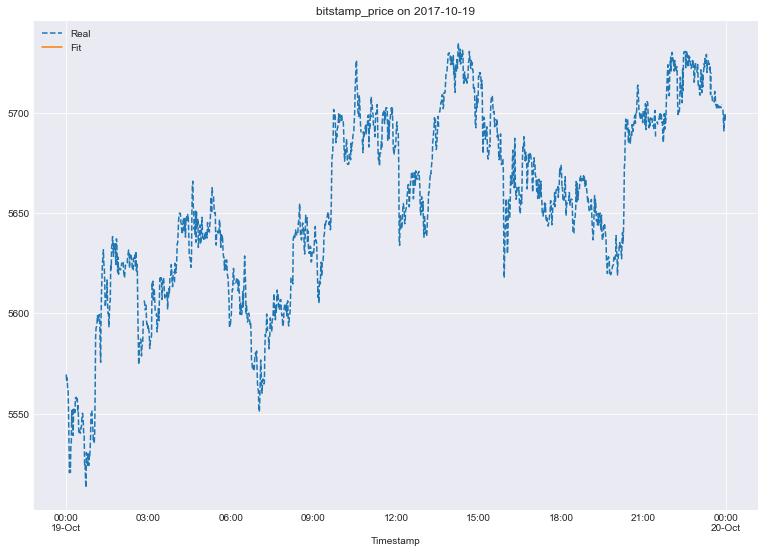

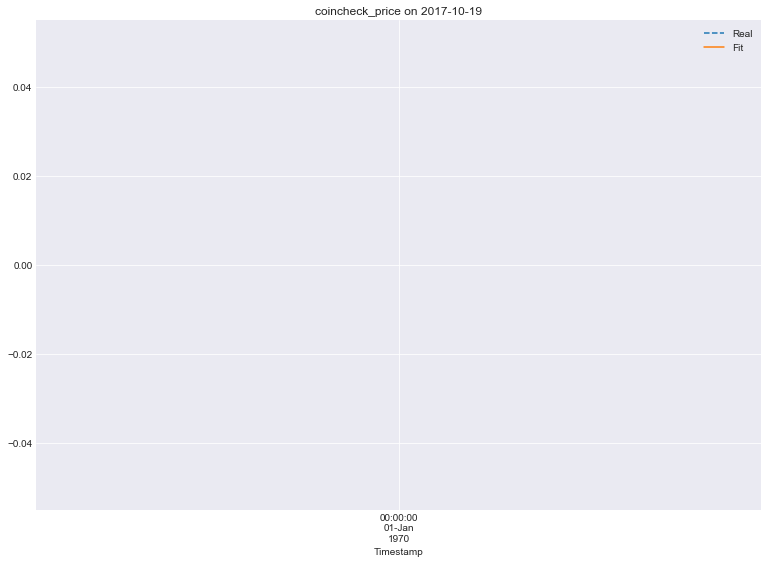

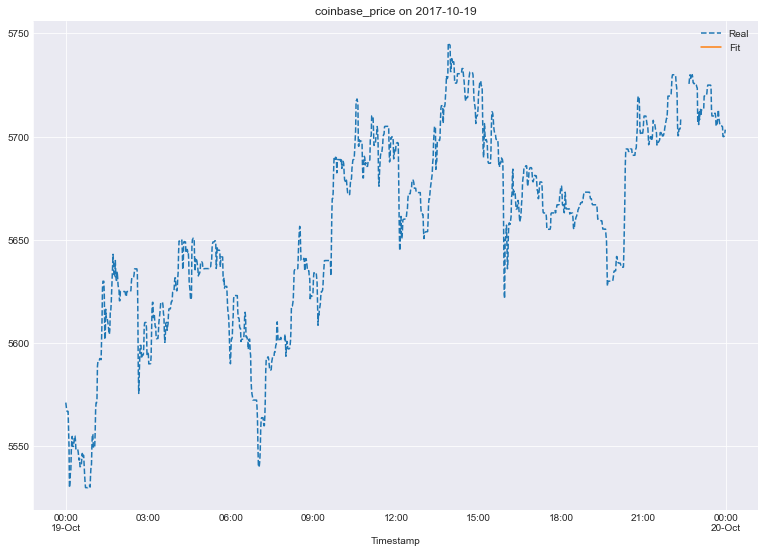

In [9]:
# Merge outputs together
for col in input_columns:
    train_target[col + '_pred'] = np.reshape(output[col], (-1,))
    test_target[col + '_pred'] = np.reshape(pred[col], (-1,))
df = (
    train_target
    .append(test_target)
    .pipe(lambda x: norm.undo_transform(x, suffix='_pred'))
)

for col in input_columns:
    fig = plt.figure(figsize=(13, 9))
    df[col].plot(label='Real', ls='--')
    df[col + '_pred'].plot(label='Fit')
    plt.title(col + " on " + date.strftime("%Y-%m-%d"))
    plt.legend()
    plt.show()